### Гежес Петр, 495 группа, Задание 1

In [21]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import warnings #как всегда, при при совмещении Python 2 и 3 вылезает куча DeprecationWarning

%matplotlib inline
warnings.simplefilter("ignore")

# 1.KNN
По сути, все, требуемое в этом задании, мы уже выполняли на семинаре (достаточно перевести шаблон на третий питон и дописать пару фрагментов)

### Генерация данных

In [22]:
a = scipy.stats.multivariate_normal.rvs(size=150, mean=[0, 3], cov=[[2, 1.5], [1.5, 2]])
b = scipy.stats.multivariate_normal.rvs(size=200, mean=[2.5, 0], cov=[[2, -0.5], [-0.5, 2]])
X_train = np.vstack([a, b])
y_train = np.hstack([np.zeros(len(a)), np.ones(len(b))])
print(X_train.shape, y_train.shape)

(350, 2) (350,)


Визуализация данных:

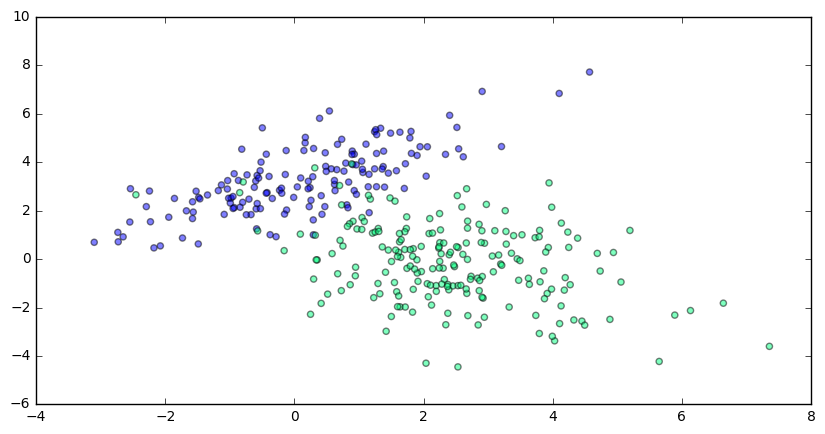

In [23]:
plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.5, cmap='winter')
plt.show()

Аналогично генерируем данные для тестирования. Сделаем тестовую выборку в два раза больше, чем обучающую:

In [24]:
a = scipy.stats.multivariate_normal.rvs(size=2 * 150, mean=[0, 3], cov=[[2, 1.5], [1.5, 2]])
b = scipy.stats.multivariate_normal.rvs(size=2 * 200, mean=[2.5, 0.5], cov=[[2, -0.5], [-0.5, 2]])
X_test = np.vstack([a, b])
y_test = np.hstack([np.zeros(len(a)), np.ones(len(b))])
print(X_test.shape, y_test.shape)

(700, 2) (700,)


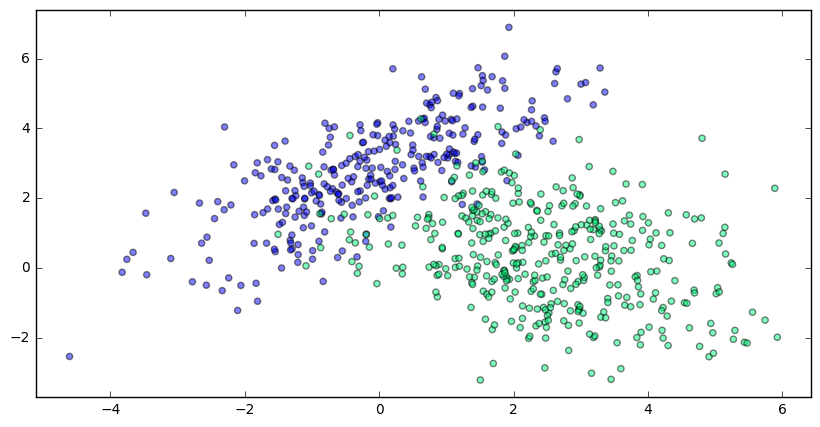

In [25]:
plt.figure(figsize=(10, 5))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=0.5, cmap='winter')
plt.xlim((min(X_test[:, 0]) - 0.5, max(X_test[:, 0]) + 0.5))
plt.ylim((min(X_test[:, 1]) - 0.5, max(X_test[:, 1]) + 0.5))
plt.show()

### Обучение модели

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score

zero_one_loss - доля неправильно классифицированных объектов из выборки

accuracy_score - доля правильно классифицированных объектов

Обучение модели (KNN):

In [27]:
model = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
model.fit(X_train, y_train)
print(model)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')


Считаем ошибку на обучении и на тесте

In [28]:
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

In [29]:
print(accuracy_score(predicted_train, y_train))
print(zero_one_loss(predicted_train, y_train))

0.971428571429
0.0285714285714


In [30]:
print(accuracy_score(predicted_test, y_test))
print(zero_one_loss(predicted_test, y_test))

0.94
0.06


### Визуализация

In [31]:
def generate_grid(train_sample, border=1, step=0.05):
    return np.meshgrid(np.arange(min(train_sample[:, 0]) - border, max(train_sample[:, 1]) + border, step), 
                       np.arange(min(train_sample[:, 1]) - border, max(train_sample[:, 1]) + border, step))

In [32]:
def create_picture(X_train, y_train, model, border=1, step=0.05, figsize=(18, 5), cmap='winter', alpha=1):
    
    # Создание сетки
    grid = generate_grid(X_train, border, step)
    grid_ravel = np.c_[grid[0].ravel(), grid[1].ravel(0)]  # Выворачивание сетки
    
    # Предсказание значений для сетки
    grid_predicted_ravel = model.predict_proba(grid_ravel)[:, 1]  # Берем вероятности для первого класса
    grid_predicted = grid_predicted_ravel.reshape(grid[0].shape)  # Подгоняем размер
    
    
    # Построение фигуры
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    plt.pcolormesh(grid[0], grid[1], grid_predicted > 0.5, cmap=cmap)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=alpha, cmap=cmap)
    plt.xlim((min(grid_ravel[:, 0]), max(grid_ravel[:, 0])))
    plt.ylim((min(grid_ravel[:, 1]), max(grid_ravel[:, 1])))
    plt.title(u'Classification {}-NN'.format(model.get_params()['n_neighbors']))
    
    plt.show()
    
    
    # Удаление лишних данных
    del(grid)
    del(grid_ravel)
    del(grid_predicted_ravel)
    del(grid_predicted)

Визуализация для k=5:

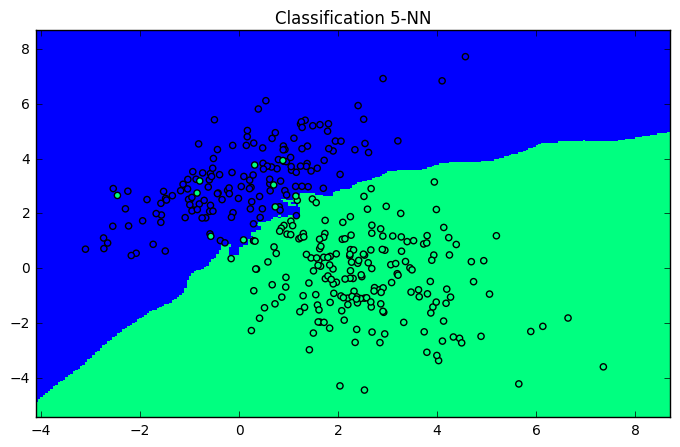

In [33]:
create_picture(X_train, y_train, KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train))

### Подбор параметра

Нарисовать результат работы классификатора для k=1,3,10,50,100:

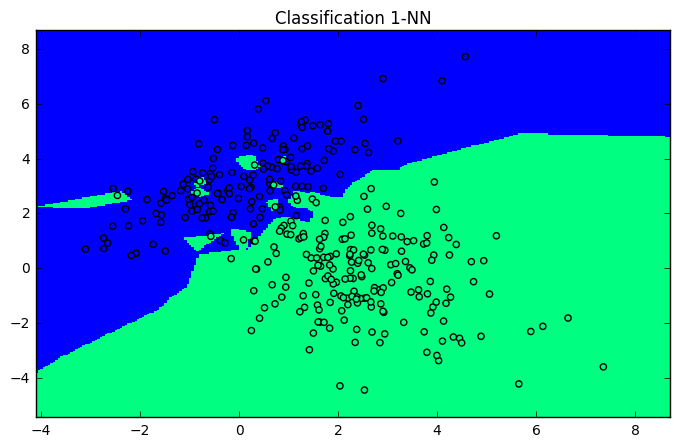

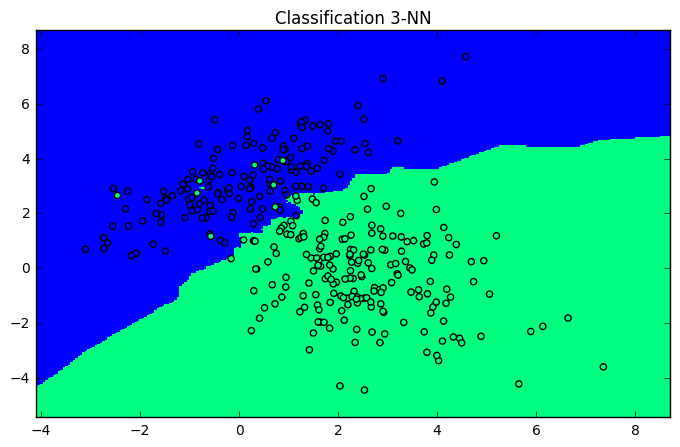

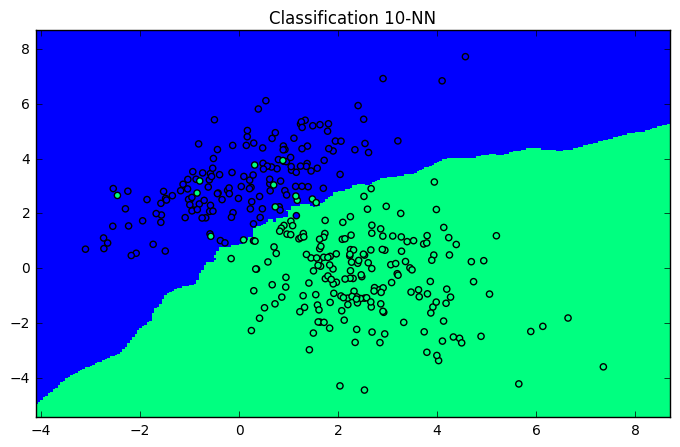

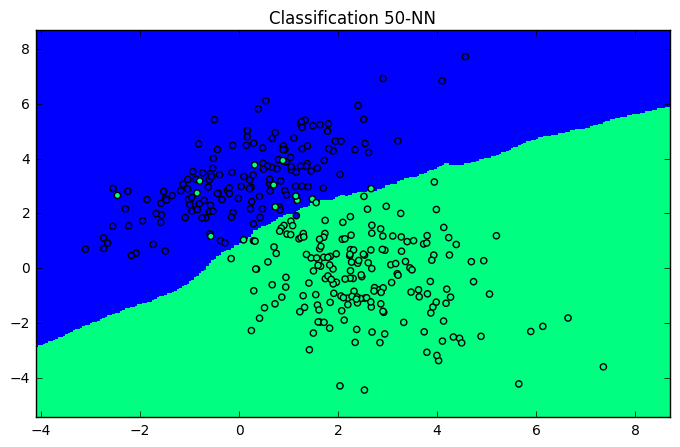

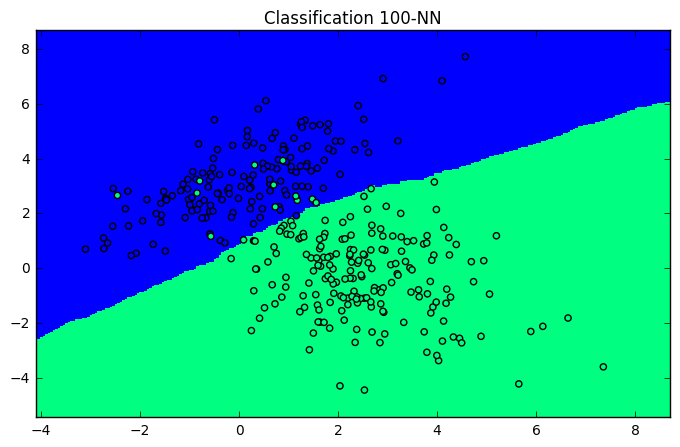

In [34]:
for n_neighbors in [1, 3, 10, 50, 100]:
    create_picture(X_train, y_train, KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train))

Считаем accuracy для моделей с разным количеством соседей:

In [35]:
scores = [accuracy_score(y_test, KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train).predict(X_test)) 
          for n in range(1, 201)]

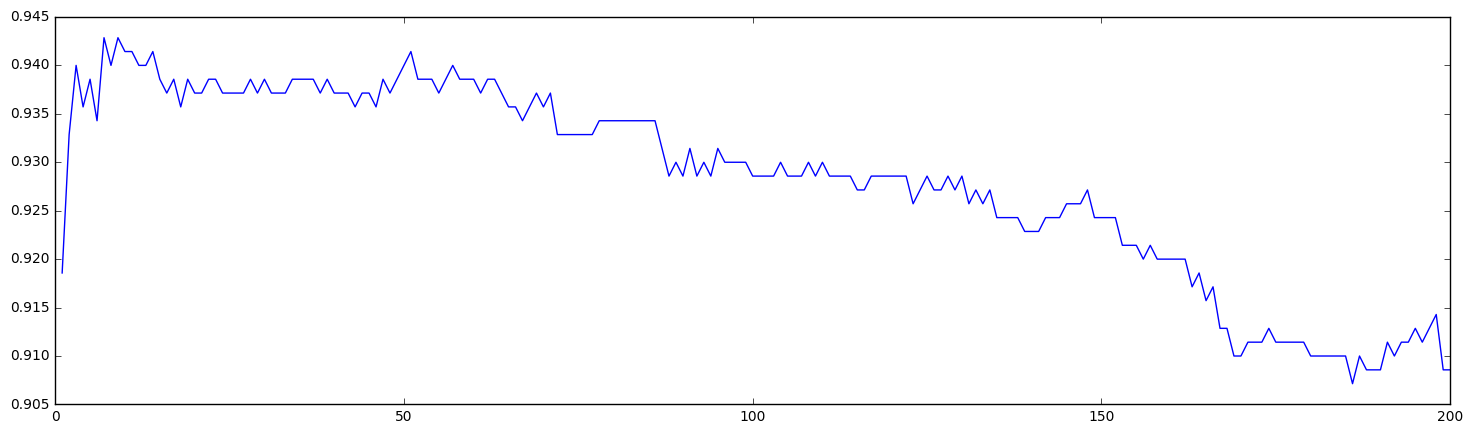

In [36]:
plt.figure(figsize=(18, 5))
plt.plot(range(1, 201), scores)
plt.show()

## Кросс-валидация

In [37]:
from sklearn.grid_search import GridSearchCV

In [38]:
params = {'n_neighbors': [i for i in range(1, 201)]}
grid_searcher = GridSearchCV(KNeighborsClassifier(), params, cv=20, n_jobs=4)
grid_searcher.fit(X_train, y_train)

means = np.array([iteration.mean_validation_score for iteration in grid_searcher.grid_scores_])
stds = np.array([np.std(iteration.cv_validation_scores) for iteration in grid_searcher.grid_scores_])

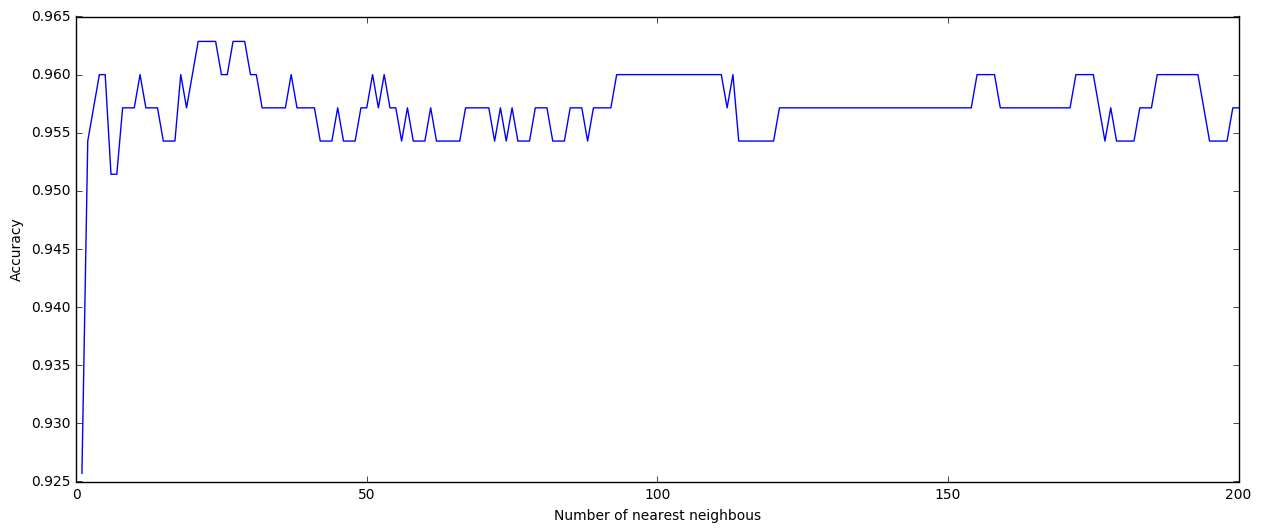

In [39]:
plt.figure(figsize=(15, 6))
plt.plot(range(1, 201), means)
plt.xlabel('Number of nearest neighbous')
plt.ylabel('Accuracy')
plt.show()

In [40]:
a = scipy.stats.multivariate_normal.rvs(size=1000, mean=[0, 3], cov=[[2, 1.5], [1.5, 2]])
b = scipy.stats.multivariate_normal.rvs(size=1500, mean=[2.5, 0.5], cov=[[2, -0.5], [-0.5, 2]])
X_train = np.vstack([a, b])
y_train = np.hstack([np.zeros(len(a)), np.ones(len(b))])
print(X_train.shape, y_train.shape)

(2500, 2) (2500,)


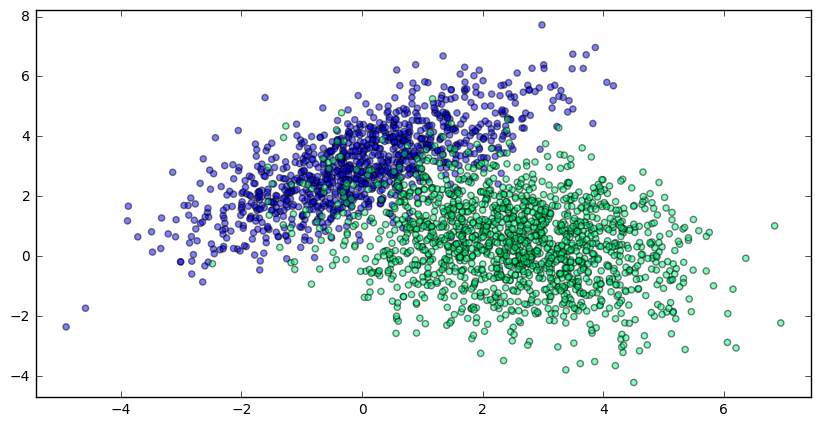

In [41]:
plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.5, cmap='winter')
plt.xlim((min(X_train[:, 0]) - 0.5, max(X_train[:, 0]) + 0.5))
plt.ylim((min(X_train[:, 1]) - 0.5, max(X_train[:, 1]) + 0.5))
plt.show()

In [42]:
params = {'n_neighbors': [i for i in range(1, 201)]}
grid_searcher = GridSearchCV(KNeighborsClassifier(), params, cv=30, n_jobs=4)
grid_searcher.fit(X_train, y_train)

means = np.array([iteration.mean_validation_score for iteration in grid_searcher.grid_scores_])
stds = np.array([np.std(iteration.cv_validation_scores) for iteration in grid_searcher.grid_scores_])

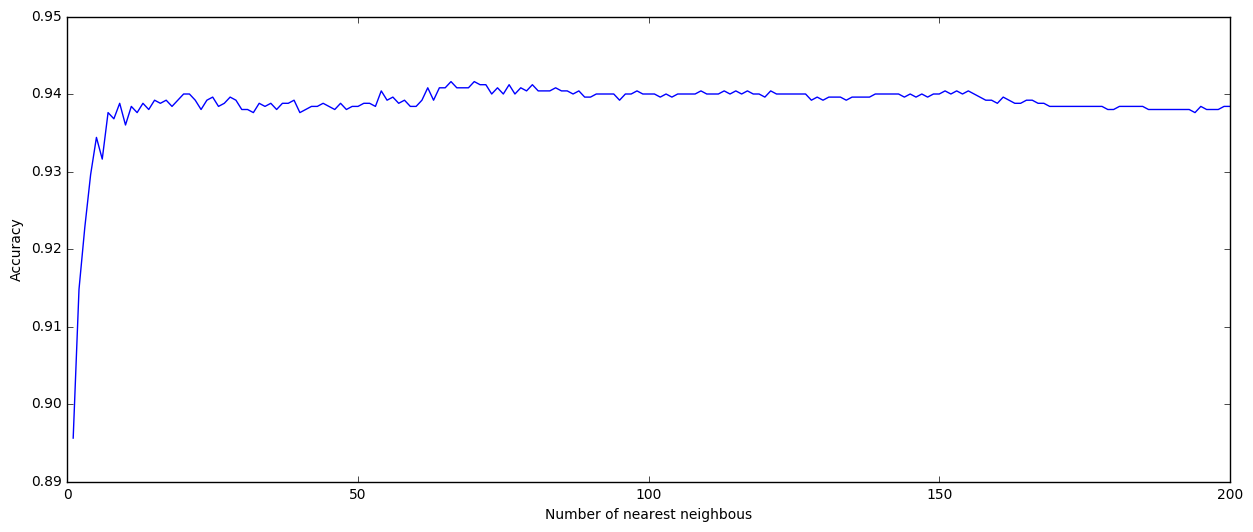

In [43]:
plt.figure(figsize=(15, 6))
plt.plot(range(1, 201), means)
plt.xlabel('Number of nearest neighbous')
plt.ylabel('Accuracy')
plt.show()

# 2. Наивный байесовский классификатор

In [44]:
import sklearn.datasets
import sklearn.naive_bayes
import sklearn.cross_validation

In [45]:
digits = sklearn.datasets.load_digits()
cancer = sklearn.datasets.load_breast_cancer()
print(digits['data'].shape)
print(cancer['data'].shape)

(1797, 64)
(569, 30)


In [46]:
def calc_cross_val_score(classifier, dataset):
    return sklearn.cross_validation.cross_val_score(classifier, dataset['data'], dataset['target']).mean()

Теперь будем смотреть резултаты для разных классификаторов и разных датасетов. Для это сначала взглянем на сами наборы:

[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]]


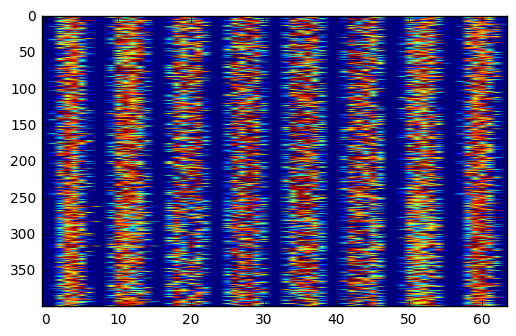

In [70]:
print(digits['data'][:2])
plt.imshow(digits['data'][:400], aspect = 0.1)
plt.show()

In [48]:
print('Bernoulli: ' + str(calc_cross_val_score(sklearn.naive_bayes.BernoulliNB(), digits)))
print('Multinom: ' + str(calc_cross_val_score(sklearn.naive_bayes.MultinomialNB(), digits)))
print('Gauss: ' + str(calc_cross_val_score(sklearn.naive_bayes.GaussianNB(), digits)))

Bernoulli: 0.825823650778
Multinom: 0.870877148974
Gauss: 0.818600380355


Значительно лучшее значение у мультиномиального. Это более чем логично, учитывая то, что все признаки дискретны

In [49]:
print(cancer['data'][:2])

[[  1.79900000e+01   1.03800000e+01   1.22800000e+02   1.00100000e+03
    1.18400000e-01   2.77600000e-01   3.00100000e-01   1.47100000e-01
    2.41900000e-01   7.87100000e-02   1.09500000e+00   9.05300000e-01
    8.58900000e+00   1.53400000e+02   6.39900000e-03   4.90400000e-02
    5.37300000e-02   1.58700000e-02   3.00300000e-02   6.19300000e-03
    2.53800000e+01   1.73300000e+01   1.84600000e+02   2.01900000e+03
    1.62200000e-01   6.65600000e-01   7.11900000e-01   2.65400000e-01
    4.60100000e-01   1.18900000e-01]
 [  2.05700000e+01   1.77700000e+01   1.32900000e+02   1.32600000e+03
    8.47400000e-02   7.86400000e-02   8.69000000e-02   7.01700000e-02
    1.81200000e-01   5.66700000e-02   5.43500000e-01   7.33900000e-01
    3.39800000e+00   7.40800000e+01   5.22500000e-03   1.30800000e-02
    1.86000000e-02   1.34000000e-02   1.38900000e-02   3.53200000e-03
    2.49900000e+01   2.34100000e+01   1.58800000e+02   1.95600000e+03
    1.23800000e-01   1.86600000e-01   2.41600000e-01 

[[  1.79900000e+01   1.03800000e+01   1.22800000e+02   1.00100000e+03
    1.18400000e-01   2.77600000e-01   3.00100000e-01   1.47100000e-01
    2.41900000e-01   7.87100000e-02   1.09500000e+00   9.05300000e-01
    8.58900000e+00   1.53400000e+02   6.39900000e-03   4.90400000e-02
    5.37300000e-02   1.58700000e-02   3.00300000e-02   6.19300000e-03
    2.53800000e+01   1.73300000e+01   1.84600000e+02   2.01900000e+03
    1.62200000e-01   6.65600000e-01   7.11900000e-01   2.65400000e-01
    4.60100000e-01   1.18900000e-01]
 [  2.05700000e+01   1.77700000e+01   1.32900000e+02   1.32600000e+03
    8.47400000e-02   7.86400000e-02   8.69000000e-02   7.01700000e-02
    1.81200000e-01   5.66700000e-02   5.43500000e-01   7.33900000e-01
    3.39800000e+00   7.40800000e+01   5.22500000e-03   1.30800000e-02
    1.86000000e-02   1.34000000e-02   1.38900000e-02   3.53200000e-03
    2.49900000e+01   2.34100000e+01   1.58800000e+02   1.95600000e+03
    1.23800000e-01   1.86600000e-01   2.41600000e-01 

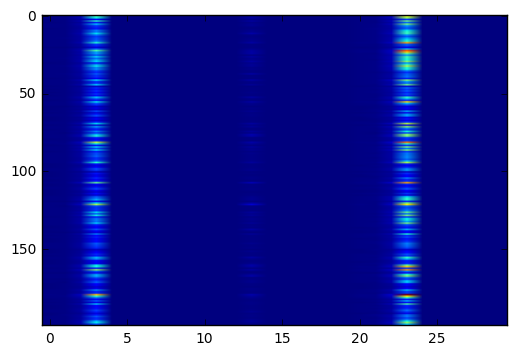

In [72]:
print(cancer['data'][:2])
plt.imshow(cancer['data'][:200], aspect = 0.1)
plt.show()

In [73]:
print('Bernoulli: ' + str(calc_cross_val_score(sklearn.naive_bayes.BernoulliNB(), cancer)))
print('Multinom: ' + str(calc_cross_val_score(sklearn.naive_bayes.MultinomialNB(), cancer)))
print('Gauss: ' + str(calc_cross_val_score(sklearn.naive_bayes.GaussianNB(), cancer)))

Bernoulli: 0.627420402859
Multinom: 0.894579040193
Gauss: 0.936749280609


Этот датасет - действительные числа из реального мира, поэтому логично предположить, что лучшие результаты будут у гауссовского.
Из утверждений верны только c и d, опять же, это можно было сказать и без практики.

# 3.Метрики в задаче регрессии

In [81]:
x_min = 0
x_max = 10
x = scipy.stats.uniform.rvs(x_min, x_max, size = 500)
y = 0.5 * x + 1 + scipy.stats.norm.rvs(loc = 0, scale = 0.2, size = 500)

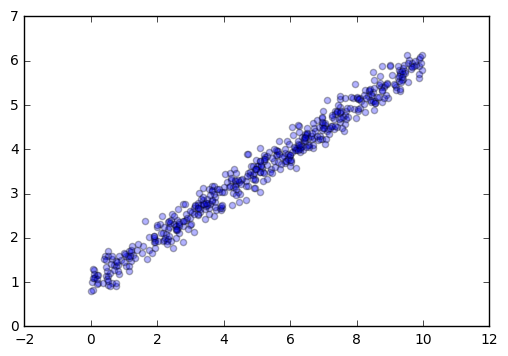

In [82]:
plt.scatter(x, y, alpha = 0.3)
plt.show()

Найдем оптимальные значения для приближения y = ax + b:

In [90]:
p_init = [0, 0]
mse_best = scipy.optimize.minimize(lambda p: np.average((p[0] * x + p[1] - y) ** 2), p_init).x
print(mse_best)

[ 0.49921082  1.0098466 ]


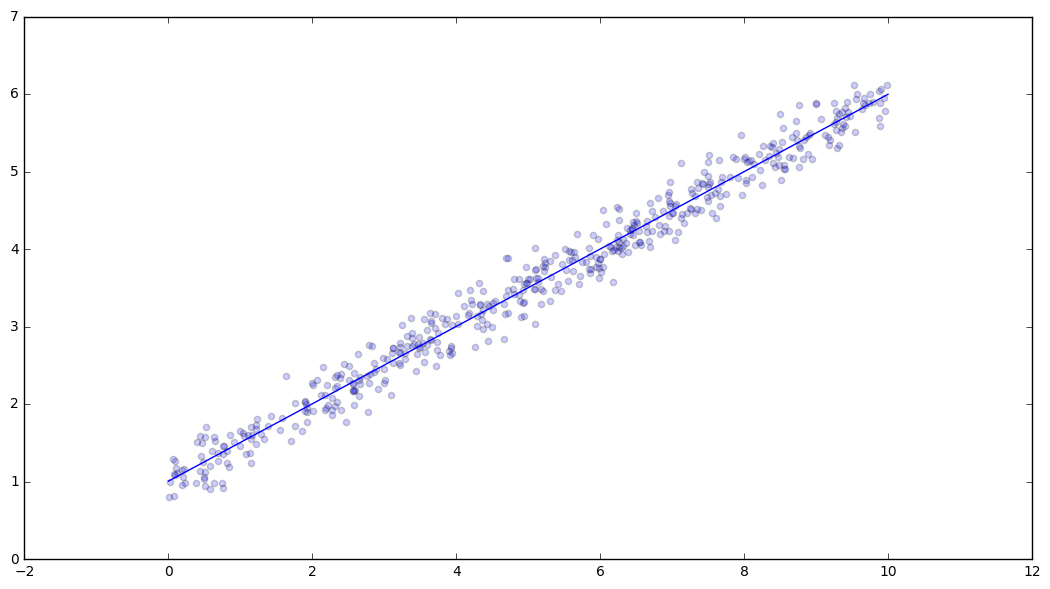

In [93]:
plt.figure(figsize = (13, 7))
plt.plot([x_min, x_max], [x_min * mse_best[0] + mse_best[1], x_max * mse_best[0] + mse_best[1]])
plt.scatter(x, y, alpha = 0.2)
plt.show()

Добавим в выборку точки из другой прямой:

In [95]:
x_add = scipy.stats.uniform.rvs(x_min, x_max, size = 75)
x = np.append(x, x_add)
y = np.append(y, scipy.stats.norm.rvs(loc = -1, scale = 0.2, size = 75))

In [97]:
mse_best = scipy.optimize.minimize(lambda p: np.average((p[0] * x + p[1] - y) ** 2), p_init).x
mae_best = scipy.optimize.minimize(lambda p: np.average(np.abs(p[0] * x + p[1] - y)), p_init).x
print('MSE: ' + str(mse_best))
print('MAE: ' + str(mae_best))

MSE: [ 0.46496713  0.63358165]
MAE: [ 0.50080159  0.96943027]


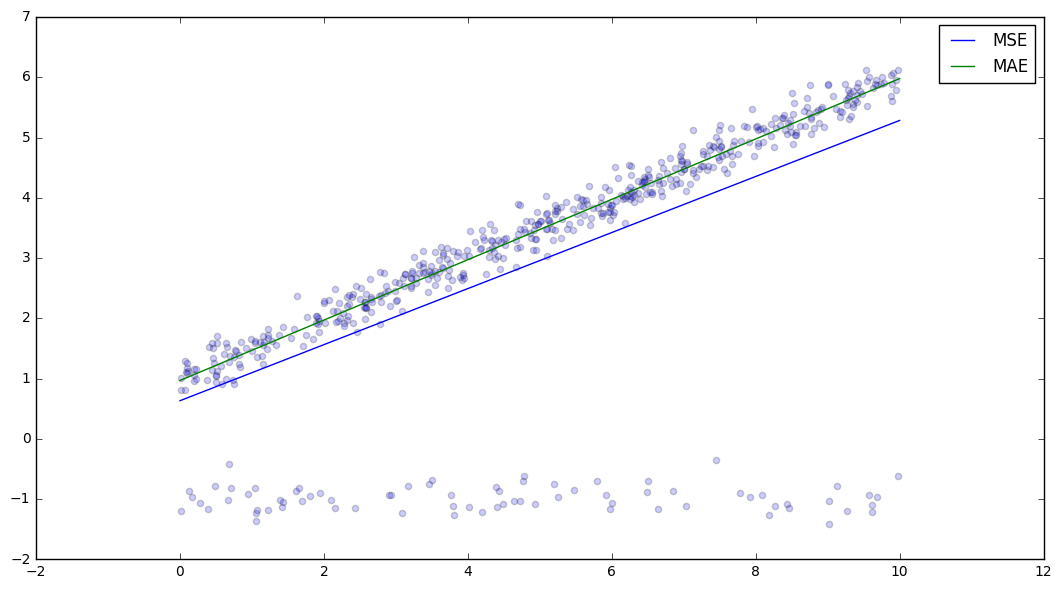

In [98]:
plt.figure(figsize = (13, 7))
plt.plot([x_min, x_max], [x_min * mse_best[0] + mse_best[1], x_max * mse_best[0] + mse_best[1]], label = 'MSE')
plt.plot([x_min, x_max], [x_min * mae_best[0] + mae_best[1], x_max * mae_best[0] + mae_best[1]], label = 'MAE')
plt.scatter(x, y, alpha = 0.2)
plt.legend()
plt.show()

Как видно, оценку от MAE гораздо больше тянет к "большинству", т.е. ее можно считать более устойчивой к группам больших отклонений, чем MSE (что, впрочем, понятно, так как квадрат растет быстрее с ростом отклонения)